In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [61]:
df_train = pd.read_csv('/Users/dominicdebiaso/Development/datasets/kaggle_animal_train.csv')
df_test = pd.read_csv('/Users/dominicdebiaso/Development/datasets/kaggle_animal_test.csv')

## EDA

In [62]:
df_train.dtypes

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

In [63]:
df_full = pd.concat((df_train, df_test))
df_full.columns = df_full.columns.str.strip()
df_full.drop(['AnimalID', 'ID'], axis=1, inplace=True)

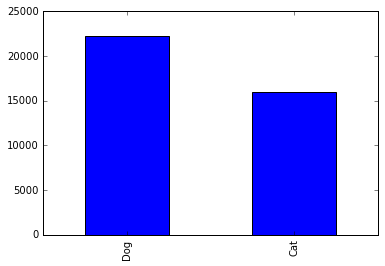

In [64]:
df_full['AnimalType'].value_counts(dropna=False).plot(kind='bar')

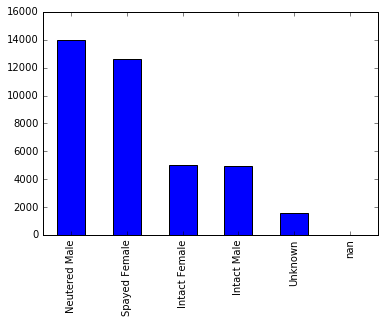

In [65]:
df_full['SexuponOutcome'].value_counts(dropna=False).plot(kind='bar')

## FE

In [66]:
def feature_engineering(df):
    # Name vs no name
    df['HasName'] = np.where(df['Name'].notnull(), 1, 0)

    # Is animal a mix
    df['isMix'] = np.where(df['Breed'].str.contains('Mix', case=False), 1, 0)

    # Simplify colors by taking first listed
    df['SimpleColor'] = df['Color'].str.extract('(\w+)', expand=False)

    # Is animal fixed
    df['Fixed'] = np.where(df['SexuponOutcome'].str.contains('Neutered|Spayed', case=False), 1, 0)

    # Sex
    df.loc[df['SexuponOutcome'].str.contains('Male', na=False), 'isMale'] = 1
    df.loc[df['SexuponOutcome'].str.contains('Female', na=False), 'isFemale'] = 1

    # Age in days
    df['AgeuponOutcomeNum'] = df['AgeuponOutcome'].str.extract('(\d+)', expand=False).astype('float')
    df.loc[df['AgeuponOutcome'].str.contains('week', na=False), 'AgeinDays'] = df['AgeuponOutcomeNum'] * 7
    df.loc[df['AgeuponOutcome'].str.contains('month', na=False), 'AgeinDays'] = df['AgeuponOutcomeNum'] * 30
    df.loc[df['AgeuponOutcome'].str.contains('year', na=False), 'AgeinDays'] = df['AgeuponOutcomeNum'] * 365

    # Datetime of outcome
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['OutcomeYear'] = df[['DateTime']].set_index('DateTime').index.year
    df['OutcomeMonth'] = df[['DateTime']].set_index('DateTime').index.month
    df['OutcomeHour'] = df[['DateTime']].set_index('DateTime').index.hour
    df.loc[(df['OutcomeHour'] >= 5) & (df['OutcomeHour'] <= 8), 'OutcomeTimeofDay'] = 'early morning'
    df.loc[(df['OutcomeHour'] >= 9) & (df['OutcomeHour'] <= 12), 'OutcomeTimeofDay'] = 'morning'
    df.loc[(df['OutcomeHour'] >= 13) & (df['OutcomeHour'] <= 17), 'OutcomeTimeofDay'] = 'afternoon'
    df.loc[(df['OutcomeHour'] >= 18) & (df['OutcomeHour'] <= 20), 'OutcomeTimeofDay'] = 'evening'
    df.loc[(df['OutcomeHour'] >= 21) | 
           ((df['OutcomeHour'] >= 1) & (df['OutcomeHour'] <= 4)), 'OutcomeTimeofDay'] = 'night'
    
    # Drop old columns and ones not used in modeul building
    df.drop(['AnimalID', 'ID', 'OutcomeSubtype', 'Name', 'Breed', 'Color', 'SexuponOutcome', 'AgeuponOutcome', 
             'AgeuponOutcomeNum', 'DateTime'], axis=1, inplace=True, errors='ignore')
    return df

## ML

In [67]:
def feature_transformation(df):
    le = LabelEncoder()
    for i in df.columns:
        df[i] = le.fit_transform(df[i])
    return df

In [68]:
# Define X and y
train = feature_engineering(df_train)
test = feature_engineering(df_test)

train_dummy = feature_transformation(train)
test_dummy = feature_transformation(df_test)

X_train = train_dummy.drop('OutcomeType', axis=1)
print(X_train.shape)
y_train = train_dummy['OutcomeType']
print(y_train.shape)

X_test = test_dummy
print(X_test.shape)

(26729, 12)
(26729,)
(11456, 12)


In [69]:
# Random Forest model
clf_tree = RandomForestClassifier(n_estimators=200)
clf_tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
df = pd.DataFrame(clf_tree.predict_proba(X_test), columns=
                 ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])
df.insert(0, 'ID', [i+1 for i in range(len(df))])

In [71]:
df.to_csv('/Users/dominicdebiaso/Desktop/kaggle_animal_shelter.csv', index=False)